# Bivariate Copulas 

## General Introduction to Copulas

A copula is a method used to describe the dependence structure between several random variables, which have been widely used in research fields, such as finance and hydrology. While some other multivariate distributions, such as a multivariate normal, allows only for a highly symmetric dependence structure with the same univariate and multivariate marginals distributions, copulas can model the joint distribution of multiple random variables separately from their marginal distributions.

The Copula is a multivariabe distribution with all univariate margins being $U(0,1)$ (Joe, 2014), which is best descrived by Sklar's Theorem. Sklar's Theorem essentially states that any multivariate joint distribution function can be decomposed into marginal distributions and a copula function that describes the dependence structure between the variables (Sklar, 1959).

**Sklar's Theorem:** Let $F$ be the joint distribution function of a multivariate random vector $(X_1, X_2, \ldots, X_n)$, with marginal distribution functions $F_1, F_2, \ldots, F_n$ for each variable. Then, there exists a copula function $C: [0,1]^n \rightarrow [0,1]$ such that for all $(x_1, x_2, \ldots, x_n)$ in the support of $F$, we have:

$$
F(x_1, x_2, \ldots, x_n) = C(F_1(x_1), F_2(x_2), \ldots, F_n(x_n)) \quad 
\tag{1}
$$

In this tutorial we will further explain bivariate copulas with the use of an example dataset  



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
os.chdir('C:/Users/jcl202/Documents/Phd/Data_exploration/Copulas/')
from marginals import *
from bivariate import *
from matplotlib import cm

## Data

The data used as an example is the Abalone dataset from the UCI database (http://archive.ics.uci.edu/ml/datasets/Abalone) and has also been showcased in a chapter on Vine copula based modelling by Czado and Nagler (2021). Abalones are marine snails whose shells have a spiral structure. The data set contains measurements on diameter, length, and several types of weight (whole, shucked, viscera and shell) of abalones, a type of marine snail. For this example, only data on the female snails are included and are loaded in below.

In [2]:
datapath = 'https://raw.githubusercontent.com/VU-IVM/vinecopula/develop/doc/sample_data.csv'
df = pd.read_csv(datapath)
df.head()

,whole,shuck,vis,shell,diameter,length,rings
0,0.6770,0.2565,0.1415,0.21,0.420,0.530,9
1,0.7775,0.2370,0.1415,0.33,0.415,0.530,20
2,0.7680,0.2940,0.1495,0.26,0.425,0.545,16
3,0.8945,0.3145,0.1510,0.32,0.440,0.550,19
4,0.6065,0.1940,0.1475,0.21,0.380,0.525,14


Here, we will only fit a bivariate copula to two variables, whole and shuck, which have been visualized in the following scatter plot

Text(0, 0.5, 'Shuck')

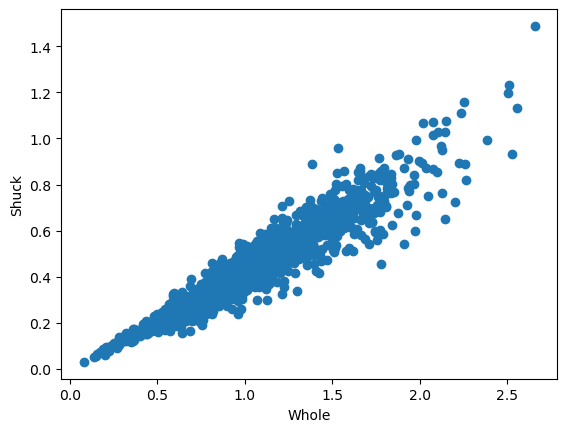

In [3]:
plt.scatter(df.whole, df.shuck)
plt.xlabel('Whole')
plt.ylabel('Shuck')

## Empirical Cumulative Distribution Function (ECDF)

In order to fit a copula to the data, the data has to be transformed into uniformly distributed marginals. This can be done by either by computing the cumulative distribution function (CDF) of each variable with a best fit distribution  (see section on [Probability Integral Transform](https://vinecopulas.readthedocs.io/en/latest/bivariatecopulas.html#Probability-Integral-Transform)), or creating psuedo data with an empirical cumulative distribution function (ECDF). Here we will first show an example using the ECDF.

***

**Algorithm 1**: computing the ECDF

***

**Input:** variable $\mathbf{x}$ with $n$ samples, where $\mathbf{x} = \{x_1, x_2, \ldots, x_n\}$.

**output:** The ECDF values $\mathbf{u} = \{u_1, u_2, \ldots, u_n\}$ represent the empirical cumulative distribution function corresponding to $X$.

1. Rank the data from 1 to $n$, where the lowest value is assigned a rank of 1, the second lowest a rank of 2, and so on, until the highest value is assigned a rank of $n$.Denote the ranks as $R = \{r_1, r_2, \ldots, r_n\}$, where $r_i$ represents the rank of $x_i$.

2. For each sample $x_i$ in the dataset compute the ECDF $u_i$ using the formula:
       $$
       u_i = \frac{{r_i - 1}}{{n - 1}} \tag{2}
       $$
   Where:

   - $r_i$ is the rank of sample $x_i$ in the sorted dataset.
   - $n$ is the total number of samples in the dataset.



***

The cumulative distribution function $F_X(x)$ of a random variable $X$ is defined as the probability that $X$ will have a value less than or equal to $x$, expressed mathematically as:
   $$
   F_X(x) = P(X \leq x) \tag{3}
   $$
   Where:

   - $F_X(x)$ is the function of $X$.
   - $X$ is a real-valued variable.
   - $P$ is the probability that $X$ will have a value less than or equal to $x$.
   
Therefore, if $x_i$ is a very low value in $X$, its corresponding value in  $U$, $u_i$, will be close to 0, while a relatively high value in  $X$ would result in a value close to 1 in $U$.


In [4]:
x = np.array(df)
u =  pseudodata(x[:,:2]) # computes the pseudodata
u1 = u[:,0]
u2 = u[:,1]

## Fitting a Copula

Once the data has been transformed, a copula can be fit to it. The following table shows the available copula types and their ID. the ID is used as an input parameter to the fitting function to indicate which copula needs to be fitted.

**Table 1**


| **ID** | **Copula** | $\mathbf{C(u_1, u_2)}$ | **Parameters** |
|---|---|---|---|
| 1 | Gaussian | $\Phi_{\theta}(\Phi^{-1}(u_1),\Phi^{-1}(u_2))$ | $\theta \in [-1, 1]$ |
| 2 | Gumbel | $\exp \!\left[-\left((-\log(u_1))^{\theta }+(-\log(u_2))^{\theta }\right)^{1/\theta }\right]$ | $\theta \in [1, \infty)$ |
| 3 | Gumbel 90 degrees | $u_2 - \exp \!\left[-\left((-\log(1-u_1))^{\theta }+(-\log(u_2))^{\theta }\right)^{1/\theta }\right]$ | $\theta \in [1, \infty)$ |
| 4 | Gumbel 180 degrees | $u_1 + u_2 - 1 + \exp \!\left[-\left((-\log(1-u_1))^{\theta }+(-\log(1-u_2))^{\theta }\right)^{1/\theta }\right]$ | $\theta \in [1, \infty)$ |
| 5 | Gumbel 270 degrees | $u_2 - \exp \!\left[-\left((-\log(u_1))^{\theta }+(-\log(1- u_2))^{\theta }\right)^{1/\theta }\right]$ | $\theta \in [1, \infty)$ |
| 6 | Clayton | $\left[\max \left\{u_1^{-\theta }+u_2^{-\theta }-1;0\right\}\right]^{-1/\theta}$ | $\theta \in [-1,\infty) \setminus \{0\}$ |
| 7 | Clayton 90 degrees | $u_2 - \left[\max \left\{(1-u_1)^{-\theta }+u_2^{-\theta }-1;0\right\}\right]^{-1/\theta}$ | $\theta \in [-1,\infty) \setminus \{0\}$ |
| 8 | Clayton 180 degrees | $u_1 + u_2 - 1 + \left[\max \left\{(1-u_1)^{-\theta }+(1-u_2)^{-\theta }-1;0\right\}\right]^{-1/\theta}$ | $\theta \in [-1,\infty) \setminus \{0\}$ |
| 9 | Clayton 270 degrees | $u_2 - \left[\max \left\{u_1^{-\theta }+(1-u_2)^{-\theta }-1;0\right\}\right]^{-1/\theta}$ | $\theta \in [-1,\infty) \setminus \{0\}$ |
| 10 | Frank | $-{\frac {1}{\theta }}\log \!\left[1+{\frac {(\exp(-\theta u)-1)(\exp(-\theta v)-1)}{\exp(-\theta )-1}}\right]$ | $\theta \in \mathbb{R} \setminus \{0\}$ |
| 11 | Joe | ${1-\left[(1-u_1)^{\theta }+(1-u_2)^{\theta }-(1-u_1)^{\theta }(1-u_2)^{\theta }\right]^{1/\theta }}$ | $\theta \in [1, \infty)$ |
| 12 | Joe 90 degrees | ${u_2 - (1-\left[(u_1)^{\theta }+(1-u_2)^{\theta }-(u_1)^{\theta }(1-u_2)^{\theta }\right]^{1/\theta }})$ | $\theta \in [1, \infty)$ |
| 13 | Joe 180 degrees | ${u_1 + u_2 -\left[(u_1)^{\theta }+(u_2)^{\theta }-(u_1)^{\theta }(u_2)^{\theta }\right]^{1/\theta }})$ | $\theta \in [1, \infty)$ |
| 14 | Joe 270 degrees | ${u-1 - (1-\left[(1-u_1)^{\theta }+(u_2)^{\theta }-(1-u_1)^{\theta }(u_2)^{\theta }\right]^{1/\theta }})$ | $\theta \in [1, \infty)$ |
| 15 | Student | $T_{\theta_2} \left( T_{\theta_2}^{-1}(u_1), T_{\theta_2}^{-1}(u_2); \theta_1 \right)$ | $\theta_1 \in [-1, 1] \text{ and } \theta_2 \in [0, \infty)$ |

Where:

- $\Phi_{\theta}$ is the bivariate standard normal cumulative distribution function with correlation parameter $\theta$.
- $\Phi^{-1}$ is the inverse of the standard normal cumulative distribution function.
- $T_{\theta_2}$ is the cumulative distribution function (CDF) of the Student's t distribution with $\theta_2$ degrees of freedom.
- $T_{\theta_2}^{-1}$ is the inverse CDF of the Student's t distribution with $\theta_2$ degrees of freedom.

When fitting a copula to data, the parameters of the selected copula family are estimated. The estimation method depends on the copula family.

In this example we will use `bestcop` function to estimate the copula that fits the data best using all copulas in Table 1. However, also a selection of copulas can be provided if the user is not interested in fitting all. The goodness of fit is measured using the Akaike Information Criterion (AIC)

The formula for the AIC is:

$$ 
\text{AIC} = -2 \ell + 2D \tag{4}
$$

Where:

- $\ell$ is the log-likelyhood with parameters $\theta$ and observed data $x_1, x_2$, is given by:


$$ 
\ell(u_1, u_2 | \theta) = \sum_{i=1}^{n} \log(c(u_1, u_2 | \theta))  \tag{5}
$$

- $D$ is the number of parameters estimated in the model.

The `bestcop` function returns the copula with the lowest AIC, which in the case below is a Survival Gumbel


In [5]:
cops = list(range(1,16)) #all copulas
cop, par, AIC = bestcop(cops, u) #fit best copula
copulas[cop] #best copula

'Gumbel180'

## Rotations
  (Klein et al., 2020)

- $C_{90}(u_1, u_2) = u_2 - C(1 - u_1, u_2)$: This rule describes the rotation of the copula by 90 degrees.
  
- $C_{180}(u_1, u_2) = u_1 + u_2 - 1 + C(1 - u_1, 1 - u_2)$: This rule describes the rotation of the copula by 180 degrees.

- $C_{270}(u_1, u_2) = u_1 - C(u_1, 1 - u_2)$: This rule describes the rotation of the copula by 270 degrees.

## Cumulative Distribution Function (CDF)

Once we have found a copula that fits the data well, we can calculate its CDF as stated in (1) ($C(u_1, u_2$)) using the `CDF` function

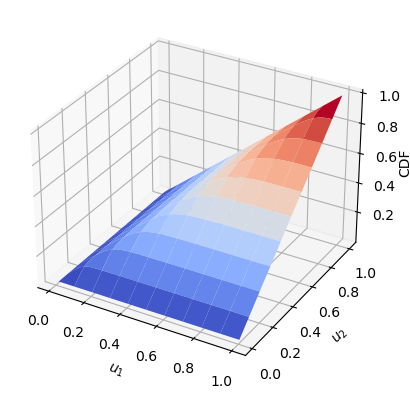

In [6]:
y = CDF(cop, u, par) #CDF
U1, U2 =  np.meshgrid(u1, u2)
x1 = 1 - np.arange(0,1,0.01)
y1 =  1 - np.arange(0,1,0.01)
X,Y = np.meshgrid(x1,y1)
z = CDF(cop, np.vstack((X.flatten(), Y.flatten())).T, par)
Z = np.resize(z,X.shape)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, rstride=10, cstride=10, linewidth=1)
ax.set_xlabel('$u_1$')
ax.set_ylabel('$u_2$')
ax.set_zlabel('CDF', rotation=90)
ax.zaxis.labelpad=-0.7 
plt.show()



## Probability Density Function (PDF)

The PDF of a copula, denoted as $c(u_1, u_2, \ldots, u_n)$, describes the density of probability around a particular point in the joint distribution space defined by the copula. It quantifies the likelihood of observing a specific combination of quantiles for the variables.


The relationship between the CDF and the PDF of a copula the same as the relationship between the CDF and the PDF of a univariate continuous random variable. Specifically, the PDF is the derivative of the CDF (Czado & Nagler, 2021).

   If $C(u_1, u_2)$ is the copula CDF, then the copula PDF $c(u_1, u_2)$ is given by taking the partial derivatives of the copula CDF with respect to each of its variables:
   $$c(u_1, u_2) = \frac{\partial C(u_1, u_2) }{\partial u_1 \partial u_2}  \tag{6}$$


To compute the PDF we can use the `PDF` function

In [7]:
p = PDF(cop, u, par) #PDF
print(p)

[6.43481561 0.86226783 5.68367378 ... 3.69354582 4.7430459  1.65446006]


## Conditional Cumulative Distribution Function (h-function)

the conditional CDF, also reffered to as the h-function, is the the conditional probability distribution of one variable given the a known value of the other variable. the h-function is defined as the partial derivative of the copula CDF, $C(u_1, u_2)$, with respect to the conditioning variable:


$$
h(u_1, u_2) = P(U_1≤u_1|U_2=u_2) =  {C_{1|2}(u_1,u_2)} = \frac{\partial C(u_1, u_2 )}{\partial u_2}  \tag{7}
$$

(Aas et al. 2007)

In our example we have to variables, Whole and Shuck. If the psuedo data of Whole is $u_1$ and of Shuck is $u_2$ and we want to calculate the h-function of Whole with respect to Shuck, ${C_{1|2}(u_1,u_2)}$, the partial derivative is used with respect to $u_2$ as in (7). The h-function can be calculated using the `hfunc` function as follows:


In [8]:
#h-functions
v2 = hfunc(cop, u1, u2, par, un = 1) #conditional CDF of Shuck (u2) given Whole (u1)
v1 = hfunc(cop, u1, u2, par, un = 2) #conditional CDF of Whole (u1) given Shuck (u2)

## Inverse Conditional Cumulative Distribution Function (inverse h-function)

The inverse h-functions computes the reverse of the h-function. for example, if $v_2 = {C_{1|2}(u_1,u_2)}$ then ${C_{1|2}^{-1}(u_1,v_2)} = u_2$ should hold. To showcase this we can use the  `hfuncinverse` function with the previously calculated $v_2$ and $u_1$ to obtain $u_2$. In the figure below it is clear that ${C_{1|2}^{-1}(u_1,v_2)} = u_2$


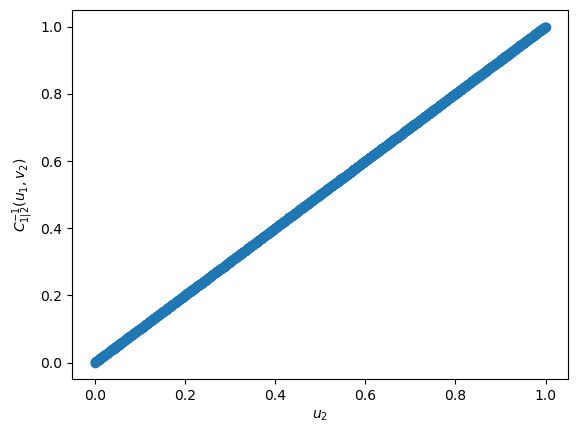

In [9]:
u2_2 =  hfuncinverse(cop, u1, v2, par, un = 1)
plt.scatter(u2,u2_2)
plt.xlabel('$u_2$')
plt.ylabel('${C_{1|2}^{-1}(u_1,v_2)}$')
plt.show()

## Generating Random Samples from a Copula

Random samples from a fitted copula can be generated using the conditional CDF previously described. the general algorithm to do so is rather simple and intuitive

***

**Algorithm 2**: generating random samples from a copula based on the conditional CDF

***

**Input**: The copula parameters $\theta$, and the number of samples $n$

**Output**: Random Samples $(\mathbf{u_1},\mathbf{u_2})$ of length $n$ from the copula with parameter $\theta$

1. Draw two independent uniform random variates $(\mathbf{u_1} ,\mathbf{v_1})$ of length $n$
2. Set $\mathbf{u_2} = {C_{1|2}^{-1}(\mathbf{u_1} ,\mathbf{v_1})}$

***

However, depending on the definition of the copula, a more efficient simulation methods can be available. For example for the Gaussian copula random samples can be generated by first obtaining a set of correlated normally distributed variates $v_1$ and $v_2$ usin Choleski’s decomposition, and then transforming these to uniform variables $u_1 = \Phi(v_1)$ and $u_2 = \Phi(v_2)$, where $\Phi$ is the standard multivariate normal.

Random samples can be generated using the `random` function, as illustrated below:

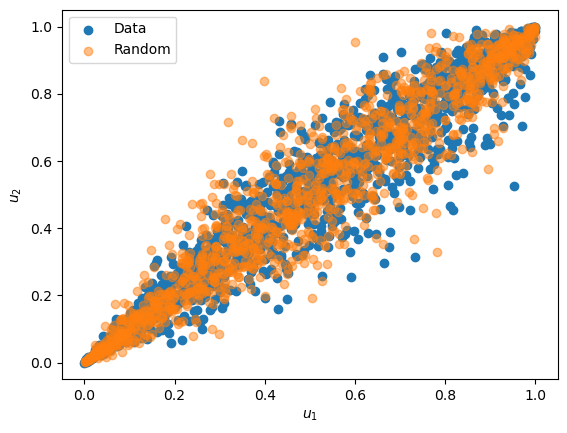

In [11]:
#generate random samples
n = len(u)
ur = random(cop, par, n)
plt.scatter(u1,u2, label = 'Data')
plt.scatter(ur[:,0], ur[:,1], alpha = 0.5, label = 'Random')
plt.xlabel('$u_1$')
plt.ylabel('$u_2$')
plt.legend()

## Generating Conditional Random Samples from a Copula

Using a copula, it is also possible to generate random samples of one variable given a fixed variable of another. This can be acieved by following the same steps that are used in Algorithm 2, however, instead of using a random Univariate for  $\mathbf{u_1}$, a known value of $\mathbf{u_1}$ can be used so $\mathbf{u_2} = {C_{2|1}^{-1}(\mathbf{u_1} ,\mathbf{v_2})}$ for specific $\mathbf{u_1}$ values. Likewise conditional values of  $\mathbf{u_1}$ can generated with known values of   $\mathbf{u_2}$ and a random independent uniform variate  $\mathbf{v_1}$ , such that  $\mathbf{u_1} = {C_{1|2}^{-1}(\mathbf{v_1}, \mathbf{u_2})} $. 

To generate conditional random samples the `randomconditional` function can be used, as showcased below:

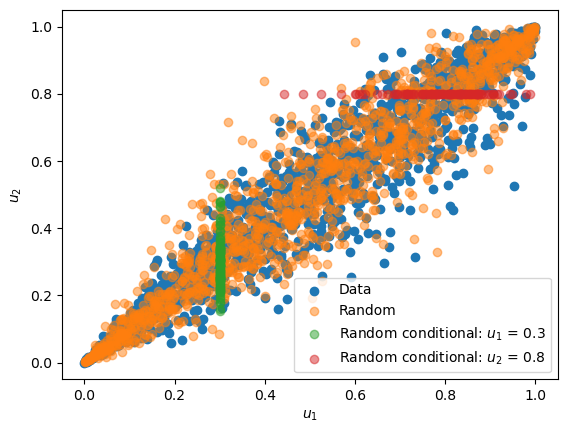

In [12]:
#generate conditional samples
n =  100 # number of samples
ui1 = 0.3 # conditional value of u1
uii2 = randomconditional(cop, ui1, par, n, un = 1) # conditional samples of u2 based on u1
ui2 = 0.8 # conditional value of u1
uii1 = randomconditional(cop, ui2, par, n, un = 2)# conditional samples of u1 based on u2
plt.scatter(u1,u2, label = 'Data')
plt.scatter(ur[:,0], ur[:,1], alpha = 0.5, label = 'Random')
plt.scatter(np.full(shape = n, fill_value = ui1), uii2, alpha = 0.5, label = 'Random conditional: $u_1$ = 0.3')
plt.scatter( uii1,np.full(shape = n, fill_value = ui2), alpha = 0.5, label = 'Random conditional: $u_2$ = 0.8')
plt.xlabel('$u_1$')
plt.ylabel('$u_2$')
plt.legend()

## Probability Integral Transform

As mentioned previously, the data can be transformed into uniformly distributed marginals by using the ECDF (explained above) or by computing the cumulative distribution function (CDF) of each variable with a best fit distribution, known as Probability Integral Transform.

The probability integral transform states that if $\mathbf{x}$ is a continuous random variable with cumulative distribution function $F_x(\mathbf{x})$, then the random variable $\mathbf{u} = F_x(\mathbf{x})$ has a uniform distribution on the interval $(0, 1)$.

to find the best CDF for each variable we have to fit a distribution to it. The best fit distribution and its parameters can be determined using the `best_fit_distribution` function.


In [13]:
#Fit marginal distributions
x1dist = best_fit_distribution(x[:,0]) # best fit distribution for Whole
x2dist = best_fit_distribution(x[:,1]) # best fit distribution for Shuck

Once the best fit distribution has been determined, the CDF can be calculated using the statistical function provided in `scipy.stats`

In [14]:
u = x[:,:2].copy()
u[:,0] = x1dist[0].cdf(u[:,0] , *x1dist[1]) # CDF of Whole
u[:,1] = x2dist[0].cdf(u[:,1] , *x2dist[1]) # CDF of Shuck

## Inverse Probability Integral Transform

In order to transform the simulated uniform datapoints to resemble the original data we can use the Inverse Probability Integral Transform, $F_{x}^{-1}(\mathbf{u})$, also known and the inverse cumulative distribution function (CDF). This can be achieved by using the previously fitted distribution and the `pff` function (Percent point function) of `scipy.stats` 


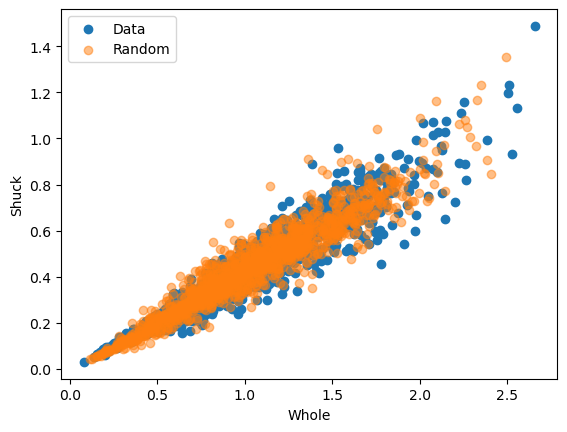

In [15]:
x1i = x1dist[0].ppf(ur[:,0] , *x1dist[1]) # calculat the ppf of the previously generated random samples of u1
x2i = x2dist[0].ppf(ur[:,1] , *x2dist[1]) # calculat the ppf of the previously generated random samples of u2
plt.scatter(x[:,0],x[:,1], label = 'Data')
plt.scatter(x1i,x2i, alpha = 0.5, label = 'Random')
plt.xlabel('Whole')
plt.ylabel('Shuck')
plt.legend()
plt.show()

## Discrete Variables

While copulas are more commonly used for continious data, they can also be a usefull tool to model discrete data. However, if the probability integral transfer method is used directly on discrete data with a discrete distribution, such that $\mathbf{u} = F_x(\mathbf{x})$, $\mathbf{u}$ would not be uniform. Therefore, additional steps are required to uniform marginals for discrete data. Therefore, the following distributional transform can be used (Mitskopoulos et al., 2022):

$$
u = F_x−(x) + V(F_x(x) − F_x−(x))
\tag{8}
$$

where:

- $F_x−(x) = P(X < x)$
- $F_x(x) = Pr(X <= x)$,
- $V$ is a random variable uniformly distributed on [0,1] independent of $X$.

To showcase this distribution transform, the _rings_ variable from the Abalone dataset will be used a discrete variable, and a copula will be fitted between the _shell_ and _rings_ variable. A discrete distribution will be fit to the _rings_ data using the `best_fit_distributiondiscrete` function. The distributional transform described in (8) can be applied using the `pseudodiscr` function. the _shell_ data can be transformed using the regular Probability Integral Transform method, after which a copula can be fit between the continious and discrete variable, as showcased below.



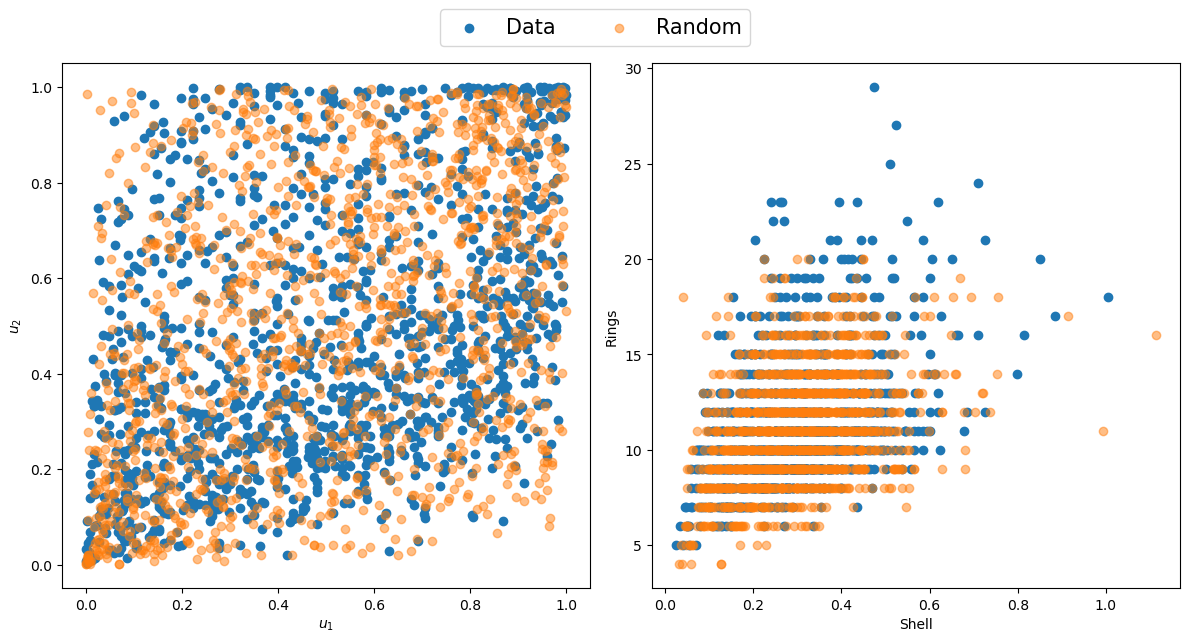

In [17]:
x = np.vstack((np.array(df.shell),  np.array(df.rings))).T #shell and rings data
xshelldist = best_fit_distribution(x[:,0]) #best fit distribution of the shell data
xringsdist =  best_fit_distributiondiscrete(x[:,1]) #best fit distribution of the rings data

xcdf = xringsdist[0].cdf(x[:,1] , *xringsdist[1]) #cdf of the rings data
xpmf = xringsdist[0].pmf(x[:,1] , *xringsdist[1]) #pmf of the rings data


u = x.copy()
u[:,0] = xshelldist[0].cdf(u[:,0] , *xshelldist[1]) #Probability Integral Transform of shell data
u[:,1] = pseudodiscr(xcdf, xpmf)  # distribution transform of rings data
u1 = u[:,0]
u2 = u[:,1]

cop, par, AIC = bestcop(cops, u) #fit best copula
copulas[cop] #best copula

u1 = u[:,0]
u2 = u[:,1]
n = len(u)
ur = random(cop, par, n) #generate random samples


x1i = xshelldist[0].ppf(ur[:,0] , *xshelldist[1]) # calculat the ppf of the previously generated random samples of u1
x2i =  xringsdist[0].ppf(ur[:,1] , * xringsdist[1]) # calculat the ppf of the previously generated random samples of u2

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].scatter(u1, u2, label='Data')
axs[0].scatter(ur[:, 0], ur[:, 1], alpha=0.5, label='Random')
axs[0].set_xlabel('$u_1$')
axs[0].set_ylabel('$u_2$')
axs[1].scatter(x[:, 0], x[:, 1])
axs[1].scatter(x1i, x2i, alpha=0.5)
axs[1].set_xlabel('Shell')
axs[1].set_ylabel('Rings')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.08), ncol=2, fontsize=15)
plt.tight_layout()
plt.show()


## References

Czado, C., & Nagler, T. (2021). Vine Copula Based Modeling. Annual Review of Statistics and Its Application, 9, 453–477. https://doi.org/10.1146/annurev-statistics-040220-101153

Joe, H. (2014). Dependence Modeling with Copulas (1st ed.). Chapman and Hall/CRC. https://doi.org/https://doi.org/10.1201/b17116

Klein, N., Kneib, T., Marra, G., & Radice, R. (2020). Bayesian mixed binary-continuous copula regression with an application to childhood undernutrition. In Flexible Bayesian Regression Modelling (pp. 121–152). Elsevier. https://doi.org/10.1016/B978-0-12-815862-3.00011-1

Mitskopoulos, L., Amvrosiadis, T., & Onken, A. (2022). Mixed vine copula flows for flexible modeling of neural dependencies. Frontiers in Neuroscience, 16. https://doi.org/10.3389/fnins.2022.910122

Sklar, M. (1959). Fonctions de repartition an dimensions et leurs marges. Publ. Inst. Statist. Univ. Paris, 8, 229–231.


